# Proyecto Máquinas de Aprendizaje
## Predicción de Incendios Forestales utilizando técnicas de Máquinas de Aprendizaje
### Daniel San Martín

Este proyecto tiene como objetivo analizar el trabajo desarrollado en el artículo "**A Data Mining Approach to Predict Forest Fires using Meteorological Data**" de Paulo Cortez y Aníbal Morais. Para esto se realiza una comparación, análisis y propuesta de modelos sobre el trabajo desarrollado por los autores mencionados.

In [19]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data manipulation

# Models
from sklearn.linear_model import LinearRegression as LR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import AdaBoostRegressor as ABR, BaggingRegressor as BR, \
    ExtraTreesRegressor as ETR, GradientBoostingRegressor as GBR, RandomForestRegressor as RFR 
from sklearn.neural_network import MLPRegressor as MLPR
from sklearn.svm import SVR

# Tools 
from sklearn.preprocessing import MinMaxScaler, StandardScaler # data pre-processing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # regression metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV # tools
from sklearn.feature_selection import RFECV
from sklearn.externals import joblib # to save models
from sklearn.utils import shuffle
import matplotlib.pyplot as plt # plots
import pandas.plotting as pdplt

import warnings
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

## Pre-procesamiento de datos

Los datos utilizados en este trabajo fueron extraidos del parque natural de Montesinho, en Trás-os-Montes región del noreste de Portugal, y contienen información sobre las áreas de terreno quemada en episodios de incendios entre enero del 2000 y diciembre del 2003.

In [2]:
# Load data
df = pd.read_csv("./data/forestfires.csv", sep = ",",header = 0)

# Categorize month and days
df.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
df.day.replace(('mon','tue','wed','thu','fri','sat','sun'),(1,2,3,4,5,6,7), inplace=True)

# Data information
print("Shape: ", df.shape)
df.info()
df.describe()

Shape:  (517, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null int64
day      517 non-null int64
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(5)
memory usage: 52.6 KB


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,7.475822,4.259188,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,2.275990,2.072929,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,1.000000,1.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,2.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,5.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,9.000000,6.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,12.000000,7.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


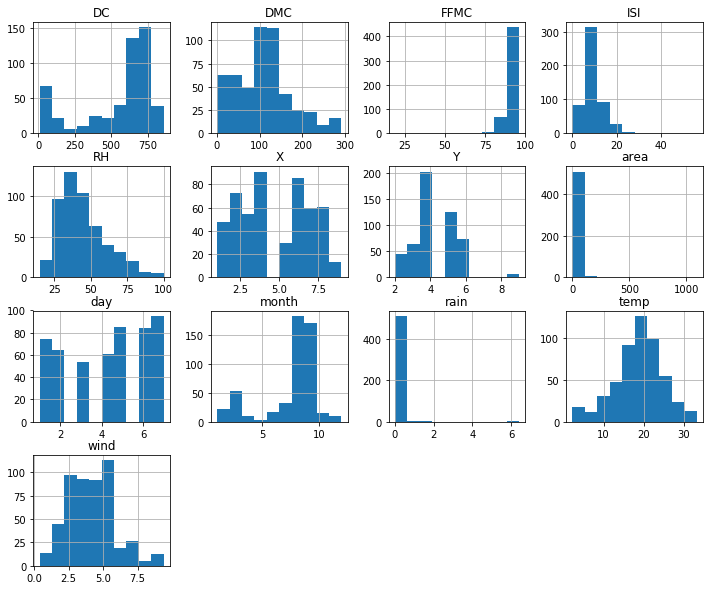

In [3]:
df.hist(figsize=(12, 10))
plt.show()

In [4]:
def plot_corr(df, size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    mat = ax.matshow(corr)
    plt.title("Correlation Matrix")
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar(mat)
    plt.show()

In [5]:
df.corr()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000,0.539548,-0.065003,-0.024922,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.063385
Y,0.539548,1.000000,-0.066292,-0.005453,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.044873
month,-0.065003,-0.066292,1.000000,-0.050837,0.291477,0.466645,0.868698,0.186597,0.368842,-0.095280,-0.086368,0.013438,0.056496
day,-0.024922,-0.005453,-0.050837,1.000000,-0.041068,0.062870,0.000105,0.032909,0.052190,0.092151,0.032478,-0.048340,0.023226
FFMC,-0.021039,-0.046308,0.291477,-0.041068,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122
DMC,-0.048384,0.007782,0.466645,0.062870,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994
DC,-0.085916,-0.101178,0.868698,0.000105,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383
ISI,0.006210,-0.024488,0.186597,0.032909,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258
temp,-0.051258,-0.024103,0.368842,0.052190,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844
RH,0.085223,0.062221,-0.095280,0.092151,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519


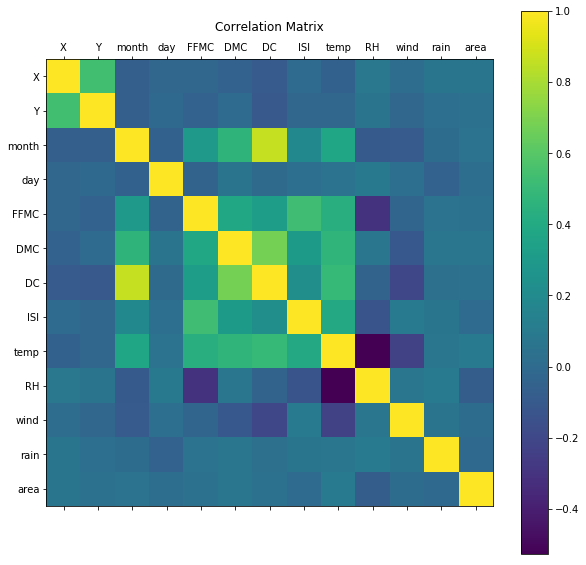

In [6]:
plot_corr(df)

Notamos que el conjunto de datos posee un total de **517** registros con **12** atributos más la variable dependiente, en este caso el área quemada. Los datos contenidos corresponden a: 
1. Datos espaciales: mapeo del terreno a coordenadas $x$ e $y$.
* Datos temporales: día y mes del año.
* Datos del sistema FWI: códigos asociados al material y cantidad de combustible, además de un índice para evaluar la velocidad del fuego.
* Datos meteorológicos: temperatura (°C), humedad relativa (%), velocidad del viento (km/hr) y precipitaciones en (mm/m²).

El área, la variable dependiente, se encuentra expresada en hectáreas (ha).

Además, los autores proponene 4 configuraciones de características para desarrollar los modelos:
1. **STFWI** utilizando los datos espaciales, temporales y FWI.
* **STM** utilizando los datos espaciales, temporales y meteorológicos.
* **FWI**  utilizando solo los datos de este sistema.
* **M** utilizando los datos meteorológicos.

A modo de comparación, se utilizarán de igual forma los datos "crudos".  Para mejorar la capacidad del modelo se utiliza la categorización utilizando la estrategia *1-of-C*.


In [20]:
df = shuffle(df, random_state=seed) # shuffle dataset to improve results

# Data configurations
# X
X = df.iloc[:,:-1]
X1C = pd.get_dummies(X, columns=['month', 'day'])
STFWI = df.loc[:, ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI']]
STFWI1C = pd.get_dummies(STFWI, columns=['month', 'day'])
STM = df.loc[:, ['X', 'Y', 'month', 'day', 'temp', 'RH', 'wind', 'rain']]
STM1C = pd.get_dummies(STM, columns=['month', 'day'])
FWI = df.loc[:, ['FFMC', 'DMC', 'DC', 'ISI']]
M = df.loc[:, ['temp', 'RH', 'wind', 'rain']]
# y
y = df.loc[:,['area']]

In [21]:
# Scalers
s1 = StandardScaler().fit(X)
s2 = StandardScaler().fit(X1C)
s3 = StandardScaler().fit(STFWI)
s4 = StandardScaler().fit(STFWI1C)
s5 = StandardScaler().fit(STM)
s6 = StandardScaler().fit(STM1C)
s7 = StandardScaler().fit(FWI)
s8 = StandardScaler().fit(M)

# Pre-processing for all configurations 
X_sc = pd.DataFrame(s1.transform(X), columns=X.columns)
X1C_sc = pd.DataFrame(s2.transform(X1C), columns=X1C.columns)
STFWI_sc = pd.DataFrame(s3.transform(STFWI), columns=STFWI.columns)
STFWI1C_sc = pd.DataFrame(s4.transform(STFWI1C), columns=STFWI1C.columns)
STM_sc = pd.DataFrame(s5.transform(STM), columns=STM.columns)
STM1C_sc = pd.DataFrame(s6.transform(STM1C), columns=STM1C.columns)
FWI_sc = pd.DataFrame(s7.transform(FWI), columns=FWI.columns)
M_sc = pd.DataFrame(s8.transform(M), columns=M.columns)

Del análisis realizado anteriormente notamos que existe mayor cantidad de incendios "pequeños", es por esto que se sugiere aplicar la transformación logarítmica $y=ln(x+1)$ para incluir un poco de simetría y además escalar considerablemente los datos.

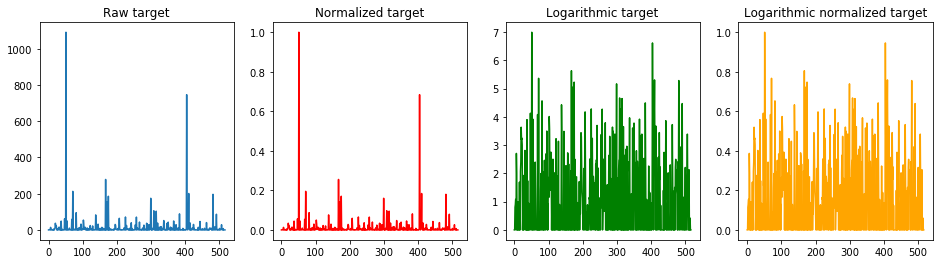

In [22]:
# Normalized target
sy = MinMaxScaler(feature_range=(0, 1))
y_sc = sy.fit_transform(y.as_matrix().reshape(len(y), 1)).flatten()

# Logarithmic target
y_log = np.log(y + 1)

# Logarithmic normalized
y_log_sc = sy.fit_transform(y_log.as_matrix().reshape(len(y), 1)).flatten()

# Comparison plot
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.plot(np.arange(len(y)), y.values)
plt.title("Raw target")
plt.subplot(1, 4, 2)
plt.plot(np.arange(len(y_sc)), y_sc, 'r')
plt.title("Normalized target")
plt.subplot(1, 4, 3)
plt.plot(np.arange(len(y_log)), y_log, 'g')
plt.title("Logarithmic target")
plt.subplot(1, 4, 4)
plt.plot(np.arange(len(y_log_sc)), y_log_sc, 'orange')
plt.title("Logarithmic normalized target")
plt.show()

Notamos la clara diferencia en el área una vez que aplicamos la transformación logaritmica.

Para evaluar la calidad de los modelos se utilizaran las méticas: R², MAE y MSE

In [23]:
def printScores(y_real, y_hat):
    print("R2: %.4f" % r2_score(y_real, y_hat))
    print("MSE: %.4f" %  mean_squared_error(y_real, y_hat))
    print("RMSE: %.4f" % np.sqrt(mean_squared_error(y_real, y_hat)))
    print("MAE: %.4f" % mean_absolute_error(y_real, y_hat))

In [24]:
def checkRFECV(model, dataset, target):
    sel = RFECV(model, step=1, cv=5, scoring='r2')
    sel = sel.fit(dataset, target)
    sel_pos = RFECVInfo(sel, plot=True)
    return sel_pos # Features selected

In [25]:
def RFECVInfo(selector, plot=False):
    print("Optimal number of features : %d" % selector.n_features_)
    print("Best score: %.4f" % np.max(selector.grid_scores_))

    if plot:
        # Plot number of features VS. cross-validation scores
        plt.figure(figsize=(10, 6))
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score")
        plt.plot(np.arange(1, 1 + len(selector.grid_scores_)), selector.grid_scores_)
        plt.grid(True)
        plt.show()
    else:
        print("Scores: ", selector.grid_scores_) # Scores
        print("Rankings: ", selector.ranking_) # Ranking
        
    # Get positions of features
    pos = np.argwhere(selector.support_).T[0]
    return pos

In [26]:
def CVScores(model):
    scores = [
        ["Train R²: ", model.cv_results_['mean_train_r2'][model.best_index_]],
        ["Train MSE: ", abs(model.cv_results_['mean_train_neg_mean_squared_error'][model.best_index_])],
        ["Train MAE: ", abs(model.cv_results_['mean_train_neg_mean_absolute_error'][model.best_index_])],
        ["Validation R²: ", model.cv_results_['mean_test_r2'][model.best_index_]],
        ["Validation MSE: ", abs(model.cv_results_['mean_test_neg_mean_squared_error'][model.best_index_])],
        ["Validation MAE: ", abs(model.cv_results_['mean_test_neg_mean_absolute_error'][model.best_index_])]
    ]
    return pd.DataFrame(scores, columns=['Metric', 'Score'])

In [27]:
# Combine all data and targets using GridSearchCV
def GSCVData(model, datasets, targets, parameters, scorers, cv, verbose=False):
    gs_models = []
    best_r2 = -np.inf
    bd, bt, bm, m = 0, 0, 0, 0
    
    # Grid search for every data-target combination
    for d in range(len(datasets)):
            
        for t in range(len(targets)):    
                
            test_model = GridSearchCV(model, parameters, cv=cv, scoring=scorers, refit='r2', n_jobs=4)
            _ = test_model.fit(datasets[d], targets[t])
                                                 
            if test_model.best_score_ > best_r2:
                best_r2 = test_model.best_score_
                bd, bt, bm = d, t, m
                
            if verbose:
                print(data_labels[d] + ", " + target_labels[t])
                CVScores(test_model)
                print("")
                
            gs_models.append(test_model)
            m += 1
        
    print("Best model configuration:")
    print("Data: %s" % data_labels[bd])
    print("Target: %s" % target_labels[bt])
    print("Parameters: %s" % gs_models[bm].best_params_)
    print("CV R2: %.4f" % gs_models[bm].best_score_)
    print("")
                
    return gs_models, bd, bt, bm

In [28]:
# Fixed variables

# Data
datasets = [STFWI_sc, STFWI1C_sc, STM_sc, STM1C_sc, FWI_sc, M_sc, X_sc, X1C_sc] # List of datasets tested
targets = [y_sc, y_log, y_log_sc] # List of targets tested

# Labels for naming
data_labels = ["STFWI", "STFWI 1C", "STM", "STM 1C", "FWI", "M", "X", "X 1C"]
target_labels = ["Scaled", "Logarithmic", "Logarithmic scaled"]

# Metric scorers
scorers = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

# Number of K-folds for cross validation
cv_ = 5

## Linear Regression

In [29]:
def searchLR(model, datasets, targets, cv, verbose=False):
    scores = np.zeros((len(datasets), len(targets), 3))
    best_lr_r2 = -np.inf
    bd, bt = 0, 0

    for d in range(len(datasets)):
        for t in range(len(targets)):
            r2 = cross_val_score(model, datasets[d], targets[t], 
                                 cv=cv, scoring='r2', n_jobs=-1)
            mse = cross_val_score(model, datasets[d], targets[t], 
                                  cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
            mae = cross_val_score(model, datasets[d], targets[t], cv=cv, 
                                  scoring='neg_mean_absolute_error', n_jobs=-1)

            scores[d, t, 0] = r2.mean()
            scores[d, t, 1] = mse.mean()
            scores[d, t, 2] = mae.mean()
            
            if scores[d, t, 0] > best_lr_r2:
                best_lr_r2 = scores[d, t, 0]
                bd, bt = d, t

            if verbose:
                print("Best configuration:")
                print("Data: %s" % data_labels[bd])
                print("Target: %s" % target_labels[bt])
                print("R2: %.4f" % scores[bd, bt, 0])
                print("MSE: %.4f" % abs(scores[bd, bt, 1]))
                print("MAE: %.4f" % abs(scores[bd, bt, 2]))    
                print("")
        
        print("Best configuration:")
        print("Data: %s" % data_labels[bd])
        print("Target: %s" % target_labels[bt])
        print("R2: %.4f" % scores[bd, bt, 0])
        print("MSE: %.4f" % abs(scores[bd, bt, 1]))
        print("MAE: %.4f" % abs(scores[bd, bt, 2]))    
        print("")
        
        return scores, bd, bt

In [30]:
sc, lr_d , lr_t = searchLR(LR(), datasets, targets, cv_)

Best configuration:
Data: STFWI
Target: Logarithmic
R2: 0.0012
MSE: 1.9406
MAE: 1.1444



Optimal number of features : 3
Best score: 0.0102


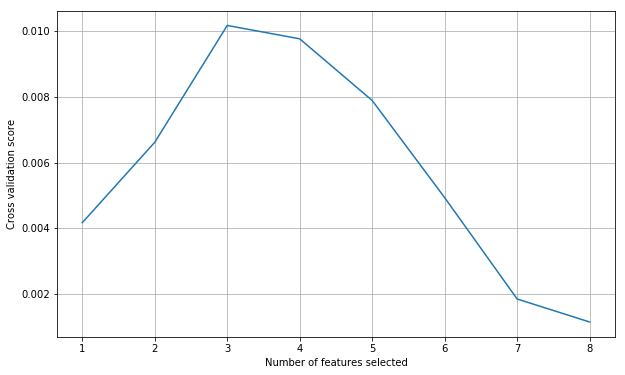

In [31]:
_ = checkRFECV(LR(), datasets[lr_d], targets[lr_t])

Luego del análisis realizado anteriormente se concluye lo siguiente:


## Decision Trees

In [33]:
dtr_parameters = {
    'criterion': ['mse', 'mae'],
    'splitter': ['best', 'random'], 
    'max_depth': [10, 50, 100]
}

In [34]:
dtr_models, dtr_d, dtr_t, dtr_m = GSCVData(DTR(), datasets, targets, dtr_parameters, scorers, cv_)

Best model configuration:
Data: FWI
Target: Scaled
Parameters: {'criterion': 'mae', 'max_depth': 10, 'splitter': 'random'}
CV R2: -0.0727



In [35]:
CVScores(dtr_models[dtr_m])

,Metric,Score
0,Train R²:,0.006319
1,Train MSE:,0.003409
2,Train MAE:,0.010364
3,Validation R²:,-0.072727
4,Validation MSE:,0.003547
5,Validation MAE:,0.012967


In [36]:
joblib.dump(dtr_models[dtr_m].best_estimator_, 'models/dt.pkl')

['models/dt.pkl']

## SVM

In [37]:
svr_parameters = [
    {'C': [1, 10, 100], 'epsilon': [0.001, 0.01, 0.1], 'kernel': ['linear']},
    {'C': [1, 10, 100], 'epsilon': [0.001, 0.01, 0.1], 
         'kernel': ['poly'], 'degree': [3, 4, 5], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100], 'epsilon': [0.001, 0.01, 0.1], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100], 'epsilon': [0.001, 0.01, 0.1], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001]}
 ]

In [38]:
svr_models, svr_d, svr_t, svr_m = GSCVData(SVR(), datasets, targets, svr_parameters, scorers, cv_)

Best model configuration:
Data: STFWI
Target: Scaled
Parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'}
CV R2: -0.0082



In [39]:
CVScores(svr_models[svr_m])

,Metric,Score
0,Train R²:,-0.027440
1,Train MSE:,0.003477
2,Train MAE:,0.015989
3,Validation R²:,-0.008222
4,Validation MSE:,0.003404
5,Validation MAE:,0.015640


Optimal number of features : 1
Best score: -0.2923


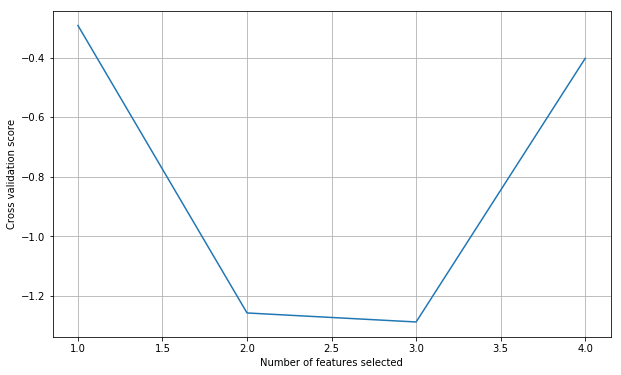

In [40]:
_ = checkRFECV(dtr_models[dtr_m].best_estimator_, datasets[dtr_d], targets[dtr_t])

In [41]:
joblib.dump(svr_models[svr_m].best_estimator_, 'models/svm.pkl')

['models/svm.pkl']

## Neural Network

In [42]:
nnr_parameters = {
    'hidden_layer_sizes': [(5, ), (10, ), (20, )], 
    'activation':  ['identity', 'logistic', 'relu'] ,
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.001, 0.01, 0.1],
    'batch_size': [50, 100, 200],
}

In [43]:
nnr_models, nnr_d, nnr_t, nnr_m = GSCVData(MLPR(random_state=seed), datasets, targets, nnr_parameters, scorers, cv_)

Best model configuration:
Data: STFWI 1C
Target: Logarithmic
Parameters: {'activation': 'logistic', 'alpha': 0.001, 'batch_size': 100, 'hidden_layer_sizes': (20,), 'solver': 'sgd'}
CV R2: 0.0047



In [44]:
CVScores(nnr_models[nnr_m])

,Metric,Score
0,Train R²:,0.017458
1,Train MSE:,1.917453
2,Train MAE:,1.149180
3,Validation R²:,0.004658
4,Validation MSE:,1.938336
5,Validation MAE:,1.153991


In [45]:
joblib.dump(nnr_models[nnr_m].best_estimator_, 'models/mlp.pkl')

['models/mlp.pkl']

## Bagging

In [46]:
bgr_parameters = {
    'n_estimators': [50, 100, 200], 
}

In [47]:
bgr_models, bgr_d, bgr_t, bgr_m = GSCVData(BR(random_state=seed, n_jobs=-1), datasets, targets, 
                                           bgr_parameters, scorers, cv_)

Best model configuration:
Data: STM 1C
Target: Logarithmic scaled
Parameters: {'n_estimators': 100}
CV R2: -0.0981



In [48]:
CVScores(bgr_models[bgr_m])

,Metric,Score
0,Train R²:,0.839820
1,Train MSE:,0.006386
2,Train MAE:,0.063245
3,Validation R²:,-0.098056
4,Validation MSE:,0.043299
5,Validation MAE:,0.168613


In [49]:
joblib.dump(bgr_models[bgr_m].best_estimator_, 'models/bagg.pkl')

['models/bagg.pkl']

## Random Forest

In [50]:
rfr_parameters = {
    'n_estimators': [10, 20, 30], 
    'criterion': ['mse', 'mae'], 
    'max_depth': [50, 100]
}

In [51]:
rfr_models, rfr_d, rfr_t, rfr_m = GSCVData(RFR(random_state=seed, n_jobs=-1), 
                                           datasets, targets, rfr_parameters, scorers, cv_)

Best model configuration:
Data: STFWI 1C
Target: Logarithmic
Parameters: {'criterion': 'mae', 'max_depth': 50, 'n_estimators': 20}
CV R2: -0.1086



In [52]:
CVScores(rfr_models[rfr_m])

,Metric,Score
0,Train R²:,0.725347
1,Train MSE:,0.537411
2,Train MAE:,0.524953
3,Validation R²:,-0.108628
4,Validation MSE:,2.162188
5,Validation MAE:,1.152761


Optimal number of features : 20
Best score: -0.0858


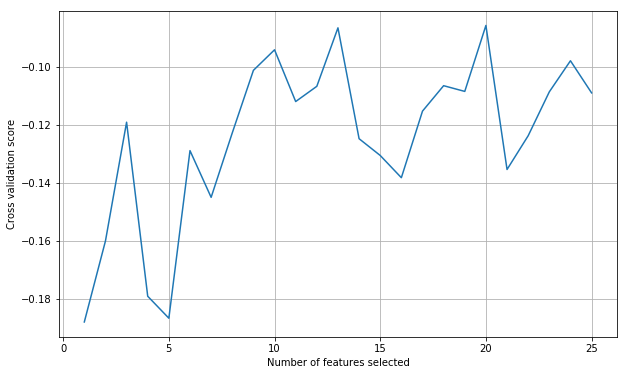

In [53]:
_ = checkRFECV(rfr_models[rfr_m].best_estimator_, datasets[rfr_d], targets[rfr_t])

In [54]:
joblib.dump(rfr_models[rfr_m].best_estimator_, 'models/rf.pkl')

['models/rf.pkl']

## Extremely Randomized Trees

In [55]:
etr_parameters = {
    'n_estimators': [50, 100, 200], 
    'criterion': ["mse", "mae"],
    'max_features': ["auto", "sqrt", "log2", None],
    'max_depth': [10, 50, 100]
}

In [56]:
etr_models, etr_d, etr_t, etr_m = GSCVData(ETR(random_state=seed, n_jobs=-1), datasets, targets, 
                                           etr_parameters, scorers, cv_)

Best model configuration:
Data: STM
Target: Logarithmic
Parameters: {'criterion': 'mse', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
CV R2: 0.0079



In [57]:
CVScores(etr_models[etr_m])

,Metric,Score
0,Train R²:,0.586523
1,Train MSE:,0.805937
2,Train MAE:,0.705744
3,Validation R²:,0.007946
4,Validation MSE:,1.927548
5,Validation MAE:,1.123908


In [58]:
joblib.dump(etr_models[etr_m].best_estimator_, 'models/etr.pkl')

['models/etr.pkl']

## Adaboost

In [59]:
abr_parameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1],
    'loss': ['linear', 'square', 'exponential'],
}

In [60]:
abr_models, abr_d, abr_t, abr_m = GSCVData(ABR(random_state=seed), datasets, targets, abr_parameters, scorers, cv_)

Best model configuration:
Data: X 1C
Target: Logarithmic scaled
Parameters: {'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 50}
CV R2: -0.0150



In [61]:
CVScores(abr_models[abr_m])

,Metric,Score
0,Train R²:,0.137886
1,Train MSE:,0.034376
2,Train MAE:,0.158821
3,Validation R²:,-0.014982
4,Validation MSE:,0.040301
5,Validation MAE:,0.169679


In [62]:
joblib.dump(abr_models[abr_m].best_estimator_, 'models/abr.pkl')

['models/abr.pkl']

## Gradient Tree Boosting

In [63]:
gbr_parameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate' : [0.1, 0.5, 1],
    'loss': ['ls', 'lad', 'huber'],
    'max_depth': [10, 20, 30],
    'criterion': ['friedman_mse', 'mse', 'mae']
}

In [64]:
gbr_models, gbr_d, gbr_t, gbr_m = GSCVData(GBR(random_state=seed), datasets, targets, gbr_parameters, scorers, cv_)

KeyboardInterrupt: 

In [ ]:
CVScores(gbr_models[gbr_m])

In [ ]:
joblib.dump(gbr_models[gbr_m].best_estimator_, 'models/gbr.pkl')